In [1]:
import pandas as pd
import numpy as np

In [2]:
table_review = pd.read_csv('yelp.csv')
table_review.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [3]:
table_review = table_review.drop(['business_id', 'date', 'review_id', 'type', 'user_id', 'cool', 'useful', 'funny'], axis = 1)

In [4]:
def simplify_reviews(d_set):
    bins = (-1, 2.1, 3.9, 5.1)
    group_names = ['negative', 'neutral', 'positive']
    categories = pd.cut(d_set.stars, bins, labels = group_names)
    d_set.stars = categories
    return d_set

In [5]:
table_review = simplify_reviews(table_review)

In [6]:
table_review.head()

,stars,text
0,positive,My wife took me here on my birthday for breakf...
1,positive,I have no idea why some people give bad review...
2,positive,love the gyro plate. Rice is so good and I als...
3,positive,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
4,positive,General Manager Scott Petello is a good egg!!!...


In [7]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import string
tok = RegexpTokenizer('\w+')
stop_words = set(stopwords.words('english'))


In [9]:
def clean_text(text):
    text_cleaned = []
    for stc in text:
        stc_tok = tok.tokenize(stc)
        words_alpha = [word.lower() for word in stc_tok if word.isalpha()]
        words_cleaned = [w for w in words_alpha if not w in stop_words]
        text_cleaned.append(words_cleaned)
    return text_cleaned

In [10]:
text_cleaned = clean_text(table_review.text)

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder().fit(table_review.stars)
labels = le.transform(table_review.stars)

from keras import utils
y_nums = 3
y_all_onehot = utils.to_categorical(labels, y_nums)

Using TensorFlow backend.


In [32]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Tokenize the text
tk = Tokenizer(num_words=6000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                lower = True, split=' ')
tk.fit_on_texts(text_cleaned)
x_all = tk.texts_to_sequences(text_cleaned)

# Pad sequences for LSTM
x_all_pad = pad_sequences(x_all, padding = 'pre', value = 0.0)

In [49]:
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Embedding, GlobalMaxPool1D

x_num_class = 6000
input_dim = x_num_class
output_dim = 256
input_length = len(x_all_pad[1])
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length, trainable = False))
lstm_model.add(Bidirectional(LSTM(64, activation = 'tanh', return_sequences = True, dropout_U = 0.2, dropout_W = 0.2)))
lstm_model.add(LSTM(64, activation = 'tanh', return_sequences = False, dropout_U = 0.2, dropout_W = 0.2))
#lstm_model.add(GlobalMaxPool1D())
lstm_model.add(Dense(64, activation = 'relu'))
lstm_model.add(Dense(3, activation = 'softmax'))
lstm_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

/Users/liuzhangshi/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, activation="tanh", return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  # Remove the CWD from sys.path while we load stuff.
/Users/liuzhangshi/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, activation="tanh", return_sequences=False, dropout=0.2, recurrent_dropout=0.2)`
  # This is added back by InteractiveShellApp.init_path()


In [50]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 449, 256)          1536000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 449, 128)          164352    
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 195       
Total params: 1,754,115
Trainable params: 218,115
Non-trainable params: 1,536,000
_________________________________________________________________


In [76]:
history = lstm_model.fit(x_all_pad, y_all_onehot, epochs = 50, batch_size = 64, 
                         validation_split = 0.2, verbose = 1)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 257s 32ms/step - loss: 0.1990 - acc: 0.9207 - val_loss: 0.9878 - val_acc: 0.7275
Epoch 2/50
8000/8000 [==============================] - 246s 31ms/step - loss: 0.2095 - acc: 0.9194 - val_loss: 0.9639 - val_acc: 0.7160
Epoch 3/50
8000/8000 [==============================] - 246s 31ms/step - loss: 0.2007 - acc: 0.9239 - val_loss: 0.9522 - val_acc: 0.7215
Epoch 4/50
8000/8000 [==============================] - 248s 31ms/step - loss: 0.1965 - acc: 0.9260 - val_loss: 0.9664 - val_acc: 0.7350
Epoch 5/50
8000/8000 [==============================] - 244s 30ms/step - loss: 0.1857 - acc: 0.9225 - val_loss: 1.0182 - val_acc: 0.7250
Epoch 6/50
8000/8000 [==============================] - 245s 31ms/step - loss: 0.1916 - acc: 0.9235 - val_loss: 0.9924 - val_acc: 0.7330
Epoch 7/50
8000/8000 [==============================] - 243s 30ms/step - loss: 0.1854 - acc: 0.9299 - val_loss: 1.0131 - val_acc: 

KeyboardInterrupt: 

In [67]:
all_words = " ".join(review for review in table_review.text)

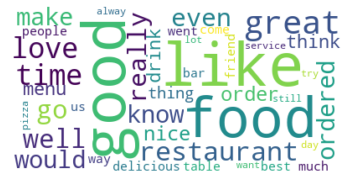

In [74]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
stopwords = stop_words
stopwords.update(['place', 'get', 'got', 'one', 'little', 'also'])
wordcloud = WordCloud(stopwords = stopwords, background_color="white", mode="RGBA", max_words=40).generate(all_words)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()